In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MSEIRS Equations
Reference: 
- https://www.freecodecamp.org/news/how-to-model-an-epidemic-with-r/ 
- https://repositorium.sdum.uminho.pt/bitstream/1822/60583/1/preprint.pdf

In our MSEIRS system, we make the below assumptions:
1. The death rate and born rate are the same, which means the number of population will not change over time.
2. Both passive maternally-derived immunity and temporary immunity weakened at the same rate

In [207]:
# define the MSEIR function with interventions
def MSEIRS_intervention(time, current_state, lam, delta, gamma, scenario, start_time, end_time):
    M, S, E, I, R = current_state
    
    beta = 0.5
    sigma = 0.25
    
    # if time is during lockdown, reset beta and sigma values
    if time >= start_time and time <= end_time:
        if scenario == "Social Distancing":
            beta = 3/4*beta
            sigma = 3/4*sigma
        elif scenario == "Mask":
            beta = 1/4*beta
            sigma = 1/4*sigma
        elif scenario == "Lockdown":
            beta = 1/5*beta
            sigma = 1/5*sigma
        
    N = M + S + E + I + R
    
    # -weakend rate * infant with immunity + new born rate * new born with immunity prob
    dM = -delta * M + lam * I * R / N
    
    # - contact rate * contact probabilities 
    # + new born losing passive immunity rate 
    # + new born rate * new born without immunity prob
    dS = -(beta * S * I) / N + delta * M + lam * I * (1 - R / N) + delta * R
    
    dE = (beta * S * I) / N - sigma * E
    
    # infectious rate - recovery rate - death rate
    dI = sigma * E - gamma * I - lam * I
    
    # recovery rate + immunity weakened rate
    dR = gamma * I - delta * R
    
    return [dM, dS, dE, dI, dR]

## Initial Parameters
beta : Transmission/Contact rate  
sigma : Infectious rate  
gamma : Recovery rate  
delta : Immunity weakened rate  
lambda : Birth/Death rate 
days : Number of days to simulate

In [208]:
# Set the parameters
lam = 0.05
delta = 0.1
gamma = 0.2  

# Start of intervention
start_time = 90
# End of intervention
end_time = 270

# Set the time points for simulation
times = np.arange(0, 366)

intervention_scenarios = ['No Intervention','Social Distancing', 'Mask', 'Lockdown']

## S - Susceptible, E - Exposed, I - Infectious, R - Recovered
M = 0: The initial number of new born with maternal immunity is set to 0.  
S = 999999: The initial number of susceptible individuals is set to 999,999.  
E = 1: The initial number of exposed individuals is set to 1.  
I = 0: The initial number of infectious individuals is set to 0.  
R = 0: The initial number of recovered individuals is set to 0.  

In [209]:
# initialise the initialise state of MSEIR
initial_state = [0, 999999, 1, 0, 0]

## solve_ivp
To solve equation with respect to time

In [210]:
from scipy.integrate import solve_ivp

In [211]:
solutions_lst =[]

for scenario in intervention_scenarios:
    # Solve the SEIR model using solve_ivp
    solution = solve_ivp(lambda t, 
                         y: MSEIRS_intervention(t, y, lam, delta, gamma, scenario, start_time, end_time), 
                         [times[0], times[-1]], 
                         initial_state, t_eval=times)
    
    solutions_lst.append(solution)

## Summary of model's statistics

In [212]:
num_scenarios = len(intervention_scenarios)
# Create an empty DataFrame with column names
df = pd.DataFrame(columns=['Intervention', 'Compartment', 'Mean', 'Min', 'Max', 
                               '25th', '50th', '75th'])

nrow = 0
for solution, idx in zip(solutions_lst, range(num_scenarios)):
    # Access the solution arrays
    M = solution.y[0]
    S = solution.y[1]
    E = solution.y[2]
    I = solution.y[3]
    R = solution.y[4]

    # Calculate summary statistics
    summary_M = np.mean(M), np.min(M), np.max(M), np.percentile(M, [25, 50, 75])
    summary_S = np.mean(S), np.min(S), np.max(S), np.percentile(S, [25, 50, 75])
    summary_E = np.mean(E), np.min(E), np.max(E), np.percentile(E, [25, 50, 75])
    summary_I = np.mean(I), np.min(I), np.max(I), np.percentile(I, [25, 50, 75])
    summary_R = np.mean(R), np.min(R), np.max(R), np.percentile(R, [25, 50, 75])

    list_summary = [summary_M, summary_S, summary_E, summary_I, summary_R]
    summary_names = ['M', 'S', 'E', 'I', 'R']
    
    for i in range(len(list_summary)):
        # Add data row by row using DataFrame.loc
        df.loc[nrow] = [intervention_scenarios[idx], summary_names[i], 
                        list_summary[i][0], list_summary[i][1], list_summary[i][2], 
                     list_summary[i][3][0], list_summary[i][3][1], list_summary[i][3][2]]
        nrow += 1

df

,Intervention,Compartment,Mean,Min,Max,25th,50th,75th
0,No Intervention,M,9166.542411,0.000000,15284.166366,3.148715,14700.490906,14719.170894
1,No Intervention,S,665087.734952,477812.018829,999999.000000,499977.300310,500095.448672,985075.925679
2,No Intervention,E,84078.092984,0.763970,136110.242503,6178.261876,121198.367507,121355.477514
3,No Intervention,I,82774.673545,0.000000,134300.569935,4390.936402,121241.373000,121375.409950
4,No Intervention,R,158892.956109,0.000000,252928.141006,4351.727327,242534.712659,242654.653581
5,Social Distancing,M,4879.046912,0.000000,15055.034936,3.118813,3403.662783,6129.693526
6,Social Distancing,S,762199.288992,486394.619274,999999.000000,626971.092134,706716.745061,985527.788812
7,Social Distancing,E,67474.590868,0.763970,130295.998578,6020.340684,95666.789641,110145.804495
8,Social Distancing,I,57364.534875,0.000000,129089.713687,4123.561024,69716.693274,96442.253162
9,Social Distancing,R,108082.538352,0.000000,249024.766508,4325.190667,124496.109241,160311.156682


In [214]:
# Extract rows based on a condition
comp_lst = ['S', 'I']
lst_df = []

for i in range(len(comp_lst)):
    # Obtain rows with similar compartment
    df_extract = df[df['Compartment'] == comp_lst[i]]
    
    # Make a copy of the extracted dataframe
    df_extract_cpy = df_extract.copy()
    # Drop string columns
    df_exclude = df_extract_cpy.drop(columns=['Intervention', 'Compartment'])
    # Calculate the percentage change for each intervention against the first row (no intervention)
    df_pct_S = df_exclude.div(df_extract_cpy.iloc[0]).subtract(1).mul(100)
    # Rename the pct column
    df_pct_S = df_pct_S.rename(columns = {'Min': 'Min Pct', 'Max': 'Max Pct'})
    
    # Combine the 2 dataframes
    df_extract = pd.concat([df_extract, df_pct_S], axis=1)
    
    # Append the combined dataframe with neccessary columns to lst_df
    lst_df.append(df_extract[['Intervention', 'Compartment', 'Min', 'Max', 'Min Pct', 'Max Pct']])

In [215]:
# Not infected (Susceptible)
lst_df[0]

,Intervention,Intervention,Compartment,Compartment,Min,Max,Min Pct,Max Pct
1,No Intervention,NaN,S,NaN,477812.018829,999999.0,0.0,0.0
6,Social Distancing,NaN,S,NaN,486394.619274,999999.0,1.79623,0.0
11,Mask,NaN,S,NaN,564028.809904,999999.0,18.044082,0.0
16,Lockdown,NaN,S,NaN,577354.933550,999999.0,20.83307,0.0


In [216]:
# Infected (Infectious)
lst_df[1]

,Intervention,Intervention,Compartment,Compartment,Min,Max,Min Pct,Max Pct
3,No Intervention,NaN,I,NaN,0.0,134300.569935,NaN,0.0
8,Social Distancing,NaN,I,NaN,0.0,129089.713687,NaN,-3.879996
13,Mask,NaN,I,NaN,0.0,122767.361910,NaN,-8.587609
18,Lockdown,NaN,I,NaN,0.0,119691.433176,NaN,-10.877941


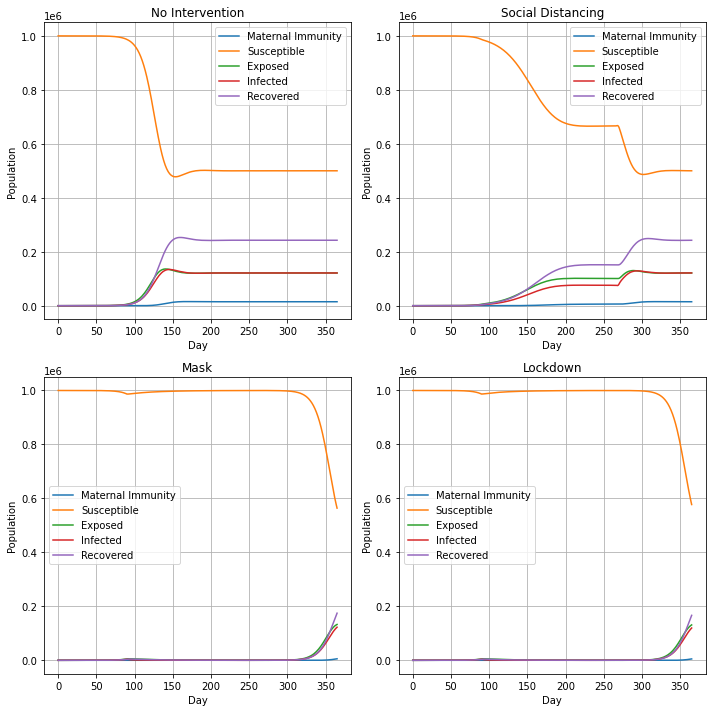

In [217]:
# Create a figure and a grid of subplots (2 rows, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10) )
# num_scenarios = len(intervention_scenarios)
for solution, ax, idx in zip(solutions_lst, axes.flatten(), range(num_scenarios)):
    # Access the solution arrays
    M = solution.y[0]
    S = solution.y[1]
    E = solution.y[2]
    I = solution.y[3]
    R = solution.y[4]
    
    ax.plot(times, M, label='Maternal Immunity')
    ax.plot(times, S, label='Susceptible')
    ax.plot(times, E, label='Exposed')
    ax.plot(times, I, label='Infected')
    ax.plot(times, R, label='Recovered')
    ax.set_xlabel('Day')
    ax.set_ylabel('Population')
    ax.set_title(intervention_scenarios[idx])
    ax.legend()
    ax.grid(True)

# adjusts the spacing between subplots
plt.tight_layout()

plt.show()